## Model Training

In [109]:
# base modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
from collections import OrderedDict

# for manipulating data
import math
import dill
import scipy

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from matplotlib import pyplot as plt

from eclyon.transforms import process_df, split_vals

In [81]:
df = pd.read_csv('cleaned_restaurant_inspection_data_2.csv')
pd.concat([df.head(), df.tail()])

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location,inspection_year,inspection_month,inspection_weekday
0,50070543,CLARO,Manhattan,284,3 AVENUE,10010.0,3477213126,Mexican,Violations were cited in the following area(s).,02B,...,106.0,2.0,6800.0,1018020.0,1.008780e+09,MN21,POINT (-73.98353061908 40.73831623132),2022,9,4
1,41708524,REICHENBACH HALL,Manhattan,5,WEST 37 STREET,10018.0,2123027744,German,Violations were cited in the following area(s).,09B,...,105.0,4.0,8400.0,1080734.0,1.008390e+09,MN17,POINT (-73.983744126629 40.750585348897),2024,5,3
2,41086967,IL SOLE,Manhattan,229233,DYCKMAN STREET,NaN,2125440406,Italian,Violations were cited in the following area(s).,02B,...,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,2024,1,3
3,50070454,Sushi Q,Bronx,1610,CROSBY AVENUE,10461.0,7188221627,Japanese,Establishment re-opened by DOHMH.,NaN,...,210.0,13.0,26602.0,2098281.0,2.041680e+09,BX10,POINT (-73.830521390885 40.844216634976),2024,6,0
4,41486460,RIVER DELI,Brooklyn,2834,COLUMBIA PLACE,NaN,7182549200,Italian,Violations were cited in the following area(s).,04L,...,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,2024,6,3
275284,41658103,CHOP-SHOP,Manhattan,254,10 AVENUE,10001.0,2128200333,Asian/Asian Fusion,Violations were cited in the following area(s).,10H,...,104.0,3.0,9300.0,1012823.0,1.007220e+09,MN13,POINT (-74.003374516952 40.748763929496),2023,1,2
275285,50096822,SOHO THAI,Manhattan,141,GRAND STREET,10013.0,2129668916,Thai,Violations were cited in the following area(s).,06C,...,102.0,1.0,4500.0,1003045.0,1.002330e+09,MN24,POINT (-73.999502156932 40.720240386394),2024,2,1
275286,50016367,EL MANATIAL,Queens,104-21,ROOSEVELT AVENUE,11368.0,7185050250,Latin American,Violations were cited in the following area(s).,08A,...,403.0,21.0,40300.0,4307628.0,4.017760e+09,QN26,POINT (-73.860725144918 40.750139665657),2025,8,3
275287,41236413,DUNKIN,Brooklyn,1575,FLATBUSH AVENUE,11210.0,3474057014,Donuts,Violations were cited in the following area(s).,02G,...,314.0,45.0,78600.0,3205908.0,3.075580e+09,BK42,POINT (-73.947175876843 40.632384405769),2025,3,1
275288,50091847,DUNKIN,Queens,13801,QUEENS BLVD,11435.0,5164727100,Donuts,Violations were cited in the following area(s).,02G,...,408.0,24.0,21400.0,4206515.0,4.096490e+09,QN35,POINT (-73.818517087227 40.708708730287),2025,7,1


In [82]:
cols_to_drop = [
    'CAMIS', 'DBA', 'BUILDING', 'STREET', 'PHONE',
    'Location', 'BBL', 'BIN', 'NTA',
    'Community Board',  
]

df_model = df.drop(columns=cols_to_drop, errors='ignore')

In [83]:
df_model.columns

Index(['BORO', 'ZIPCODE', 'CUISINE DESCRIPTION', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'INSPECTION TYPE',
       'Latitude', 'Longitude', 'Council District', 'Census Tract',
       'inspection_year', 'inspection_month', 'inspection_weekday'],
      dtype='object')

In [97]:
X, y, nas = process_df(df_model, y_field = 'SCORE')

In [98]:
pd.concat([X.head(), X.tail()])

,BORO,ZIPCODE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,INSPECTION TYPE,Latitude,Longitude,Council District,Census Tract,inspection_year,inspection_month,inspection_weekday,ZIPCODE_na,Latitude_na,Longitude_na,Council District_na,Census Tract_na
0,3,10010.0,57,5,2,75,1,3,40.738316,-73.983531,2.0,6800.0,2022,9,4,False,False,False,False,False
1,3,10018.0,38,5,54,131,3,3,40.750585,-73.983744,4.0,8400.0,2024,5,3,False,False,False,False,False
2,3,11101.0,49,5,2,75,1,2,0.000000,0.000000,20.0,17600.0,2024,1,3,True,False,False,True,True
3,1,10461.0,50,3,0,0,2,4,40.844217,-73.830521,13.0,26602.0,2024,6,0,False,False,False,False,False
4,2,11101.0,49,5,27,23,1,2,0.000000,0.000000,20.0,17600.0,2024,6,3,True,False,False,True,True
275284,3,10001.0,5,5,65,126,3,3,40.748764,-74.003375,3.0,9300.0,2023,1,2,False,False,False,False,False
275285,3,10013.0,87,5,42,67,1,3,40.720240,-73.999502,1.0,4500.0,2024,2,1,False,False,False,False,False
275286,4,11368.0,54,5,50,22,3,2,40.750140,-73.860725,21.0,40300.0,2025,8,3,False,False,False,False,False
275287,2,11210.0,28,5,6,9,1,2,40.632384,-73.947176,45.0,78600.0,2025,3,1,False,False,False,False,False
275288,4,11435.0,28,5,6,9,1,2,40.708709,-73.818517,24.0,21400.0,2025,7,1,False,False,False,False,False


### Divide the training set and the test set

In [99]:
n_total = len(df_model)
print('full number of data points : {}'.format(n_total))

full number of data points : 275289


In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("validation set size:", X_valid.shape)

Training set size: (220231, 20)
validation set size: (55058, 20)


### Train the random forest model

In [101]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [102]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [66]:
model_1 = RandomForestRegressor(
    n_estimators = 800, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    # other
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_1.fit(X_train, y_train)
print_score(model_1, X_train, y_train, X_valid, y_valid)

RMSE on train set: 13.1281
RMSE on valid set: 14.2874
R^2 on train set: 0.5125
R^2 on valid set: 0.4125
R^2 on oob set: 0.4145


In [67]:
model_2 = RandomForestRegressor(
    n_estimators = 800, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    max_features = 'sqrt', 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    # other
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_2.fit(X_train, y_train)
print_score(model_2, X_train, y_train, X_valid, y_valid)

RMSE on train set: 13.5048
RMSE on valid set: 14.4088
R^2 on train set: 0.4841
R^2 on valid set: 0.4025
R^2 on oob set: 0.4030


In [ ]:
trees = model_2.estimators_
point = [X_valid.iloc[0, :]]
preds = np.asarray([tree.predict(point) for tree in trees])
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid) for tree in model_2.estimators_]) # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds[:,0], model_2.predict(point)[0], np.mean(preds[:,0]), y_valid[0]

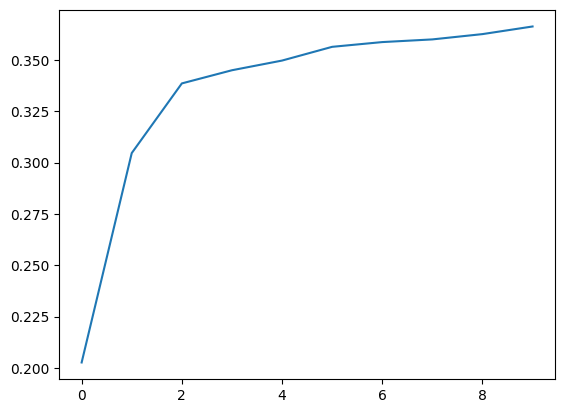

In [69]:
plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis = 0)) 
    for num_trees in range(1, 11)
])

### Cross validation

In [ ]:
model_3 = RandomForestRegressor(
    n_estimators = 800,
    max_depth = 15, 
    min_samples_split = 2,
    max_features = None,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
)

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

scores = cross_val_score(model_3, X_train, y_train, cv = cv, n_jobs = -1)
print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.41881069 0.42409259 0.42464998 0.40880999 0.41413765]
r2 is 0.418 with a standard deviation of 0.006


### Feature important

The importance of built-in features

ACTION: 0.4121
VIOLATION CODE: 0.0801
INSPECTION TYPE: 0.0686
VIOLATION DESCRIPTION: 0.0541
inspection_year: 0.0509
Latitude: 0.0508
Longitude: 0.0492
Census Tract: 0.0437
CUISINE DESCRIPTION: 0.0434
ZIPCODE: 0.0355
inspection_month: 0.0334
Council District: 0.0255
inspection_weekday: 0.0226
CRITICAL FLAG: 0.0214
BORO: 0.0067
Council District_na: 0.0007
Census Tract_na: 0.0007
ZIPCODE_na: 0.0004
Latitude_na: 0.0001
Longitude_na: 0.0001


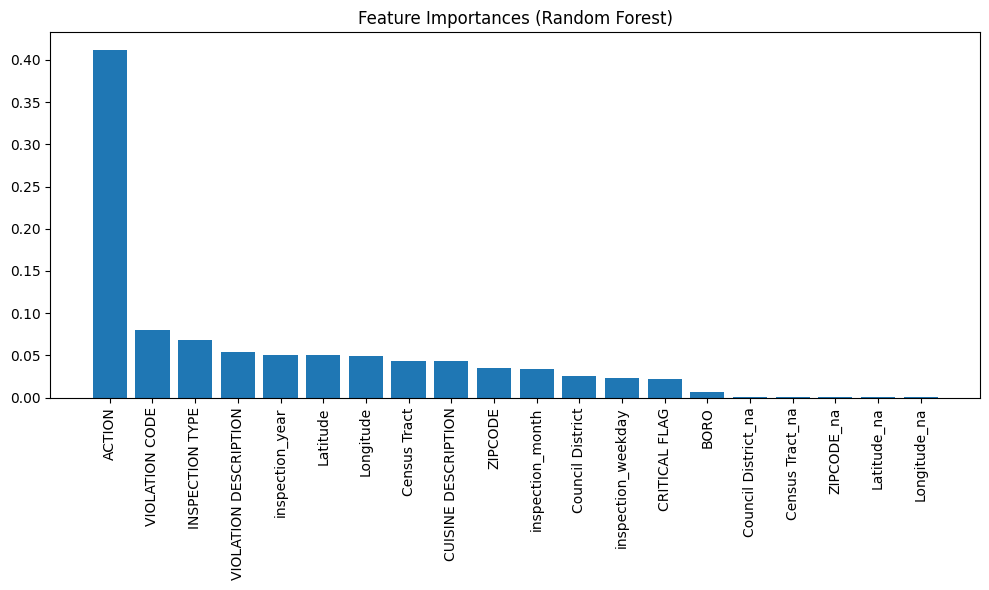

In [71]:
model_2.fit(X_train, y_train)

importances = model_2.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Permutation Importance

/var/folders/5y/b6cqgch533773c9dm5spwwx00000gn/T/ipykernel_31369/3557422422.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])


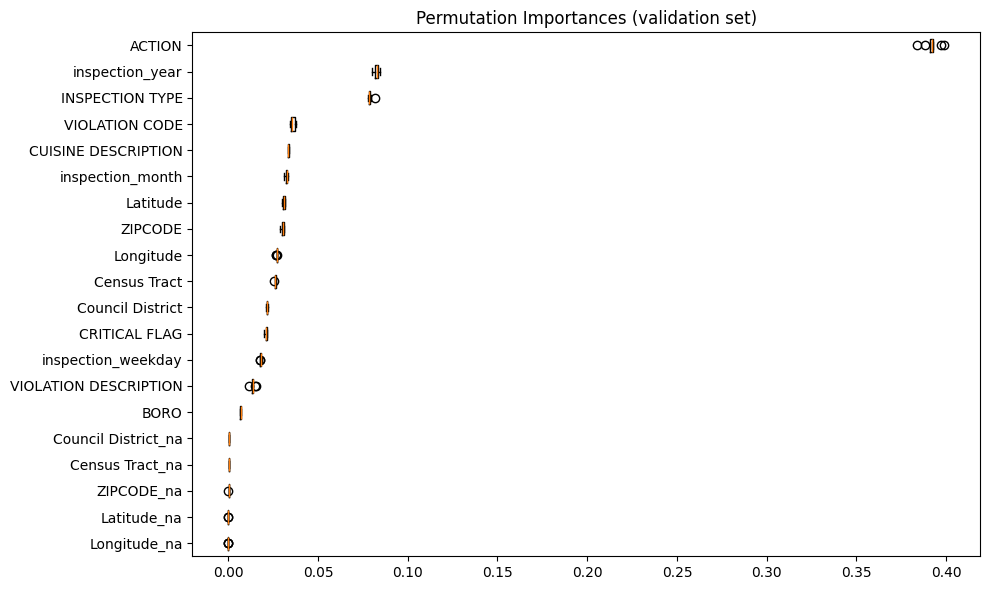

In [74]:
r = permutation_importance(model_2, X_valid, y_valid, n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])
plt.title("Permutation Importances (validation set)")
plt.tight_layout()
plt.show()

In [112]:
bool_filter = r.importances_mean > 0.005
bool_filter

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False])

the Spearman rank-order correlation matrix 

In [103]:
len(X.columns)

20

In [106]:
X.columns

Index(['BORO', 'ZIPCODE', 'CUISINE DESCRIPTION', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'INSPECTION TYPE', 'Latitude',
       'Longitude', 'Council District', 'Census Tract', 'inspection_year',
       'inspection_month', 'inspection_weekday', 'ZIPCODE_na', 'Latitude_na',
       'Longitude_na', 'Council District_na', 'Census Tract_na'],
      dtype='object')

In [107]:
cols = X.columns.tolist()